### Name: Ntwali Bruno Bahongere
#### Course: Advanced Big Data and Data Mining
#### Residency Project_Shoppers Behavior Analysis

In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score, make_scorer


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download latest version
path = kagglehub.dataset_download("subhajournal/shoppers-behavior-and-revenue")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\nBruno\.cache\kagglehub\datasets\subhajournal\shoppers-behavior-and-revenue\versions\1


In [3]:
# importing data to pandas dataframe
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# Data Exploration and Initial Analysis
print("Dataset Shape:", df.shape)
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nDataset Info:")
df.info()
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (12330, 18)

Column Names and Data Types:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administ

In [5]:
# Checcking for missing values
missing_values = df.isnull().sum()
print(missing_values)

print("\nMissing values percentage:")
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_df)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Missing values percentage:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []


In [6]:
# Check for duplicate records
print(f"Total records: {len(df)}")
print(f"Duplicate records: {df.duplicated().sum()}")
print(f"Unique records: {len(df) - df.duplicated().sum()}")

if df.duplicated().sum() > 0:
    print("\nDuplicate records preview:")
    print(df[df.duplicated()].head())

# Check for negative values in numeric columns that shouldn't be negative
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nChecking for negative values in numeric columns:")
for col in numeric_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count} negative values")

# Check for outliers using IQR method
print("\nChecking for potential outliers (values beyond 3*IQR):")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} potential outliers ({len(outliers)/len(df)*100:.2f}%)")

# Check categorical variables
print("\nCategorical variables unique values:")
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values - {df[col].unique()}")

Total records: 12330
Duplicate records: 125
Unique records: 12205

Duplicate records preview:
     Administrative  Administrative_Duration  Informational  \
158               0                      0.0              0   
159               0                      0.0              0   
178               0                      0.0              0   
418               0                      0.0              0   
456               0                      0.0              0   

     Informational_Duration  ProductRelated  ProductRelated_Duration  \
158                     0.0               1                      0.0   
159                     0.0               1                      0.0   
178                     0.0               1                      0.0   
418                     0.0               1                      0.0   
456                     0.0               1                      0.0   

     BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
158          0.

In [7]:
if 'df_cleaned' not in locals():
	df_cleaned = df.copy().drop_duplicates()

print("\nData types after cleaning:")
print(df_cleaned.dtypes)

print("\nFirst 5 rows of cleaned data:")
print(df_cleaned.head())


Data types after cleaning:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

First 5 rows of cleaned data:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0           

In [8]:
# Explanatory Data Analysis (EDA) 

# Set plotting style for better visualizations
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3


Numerical features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']


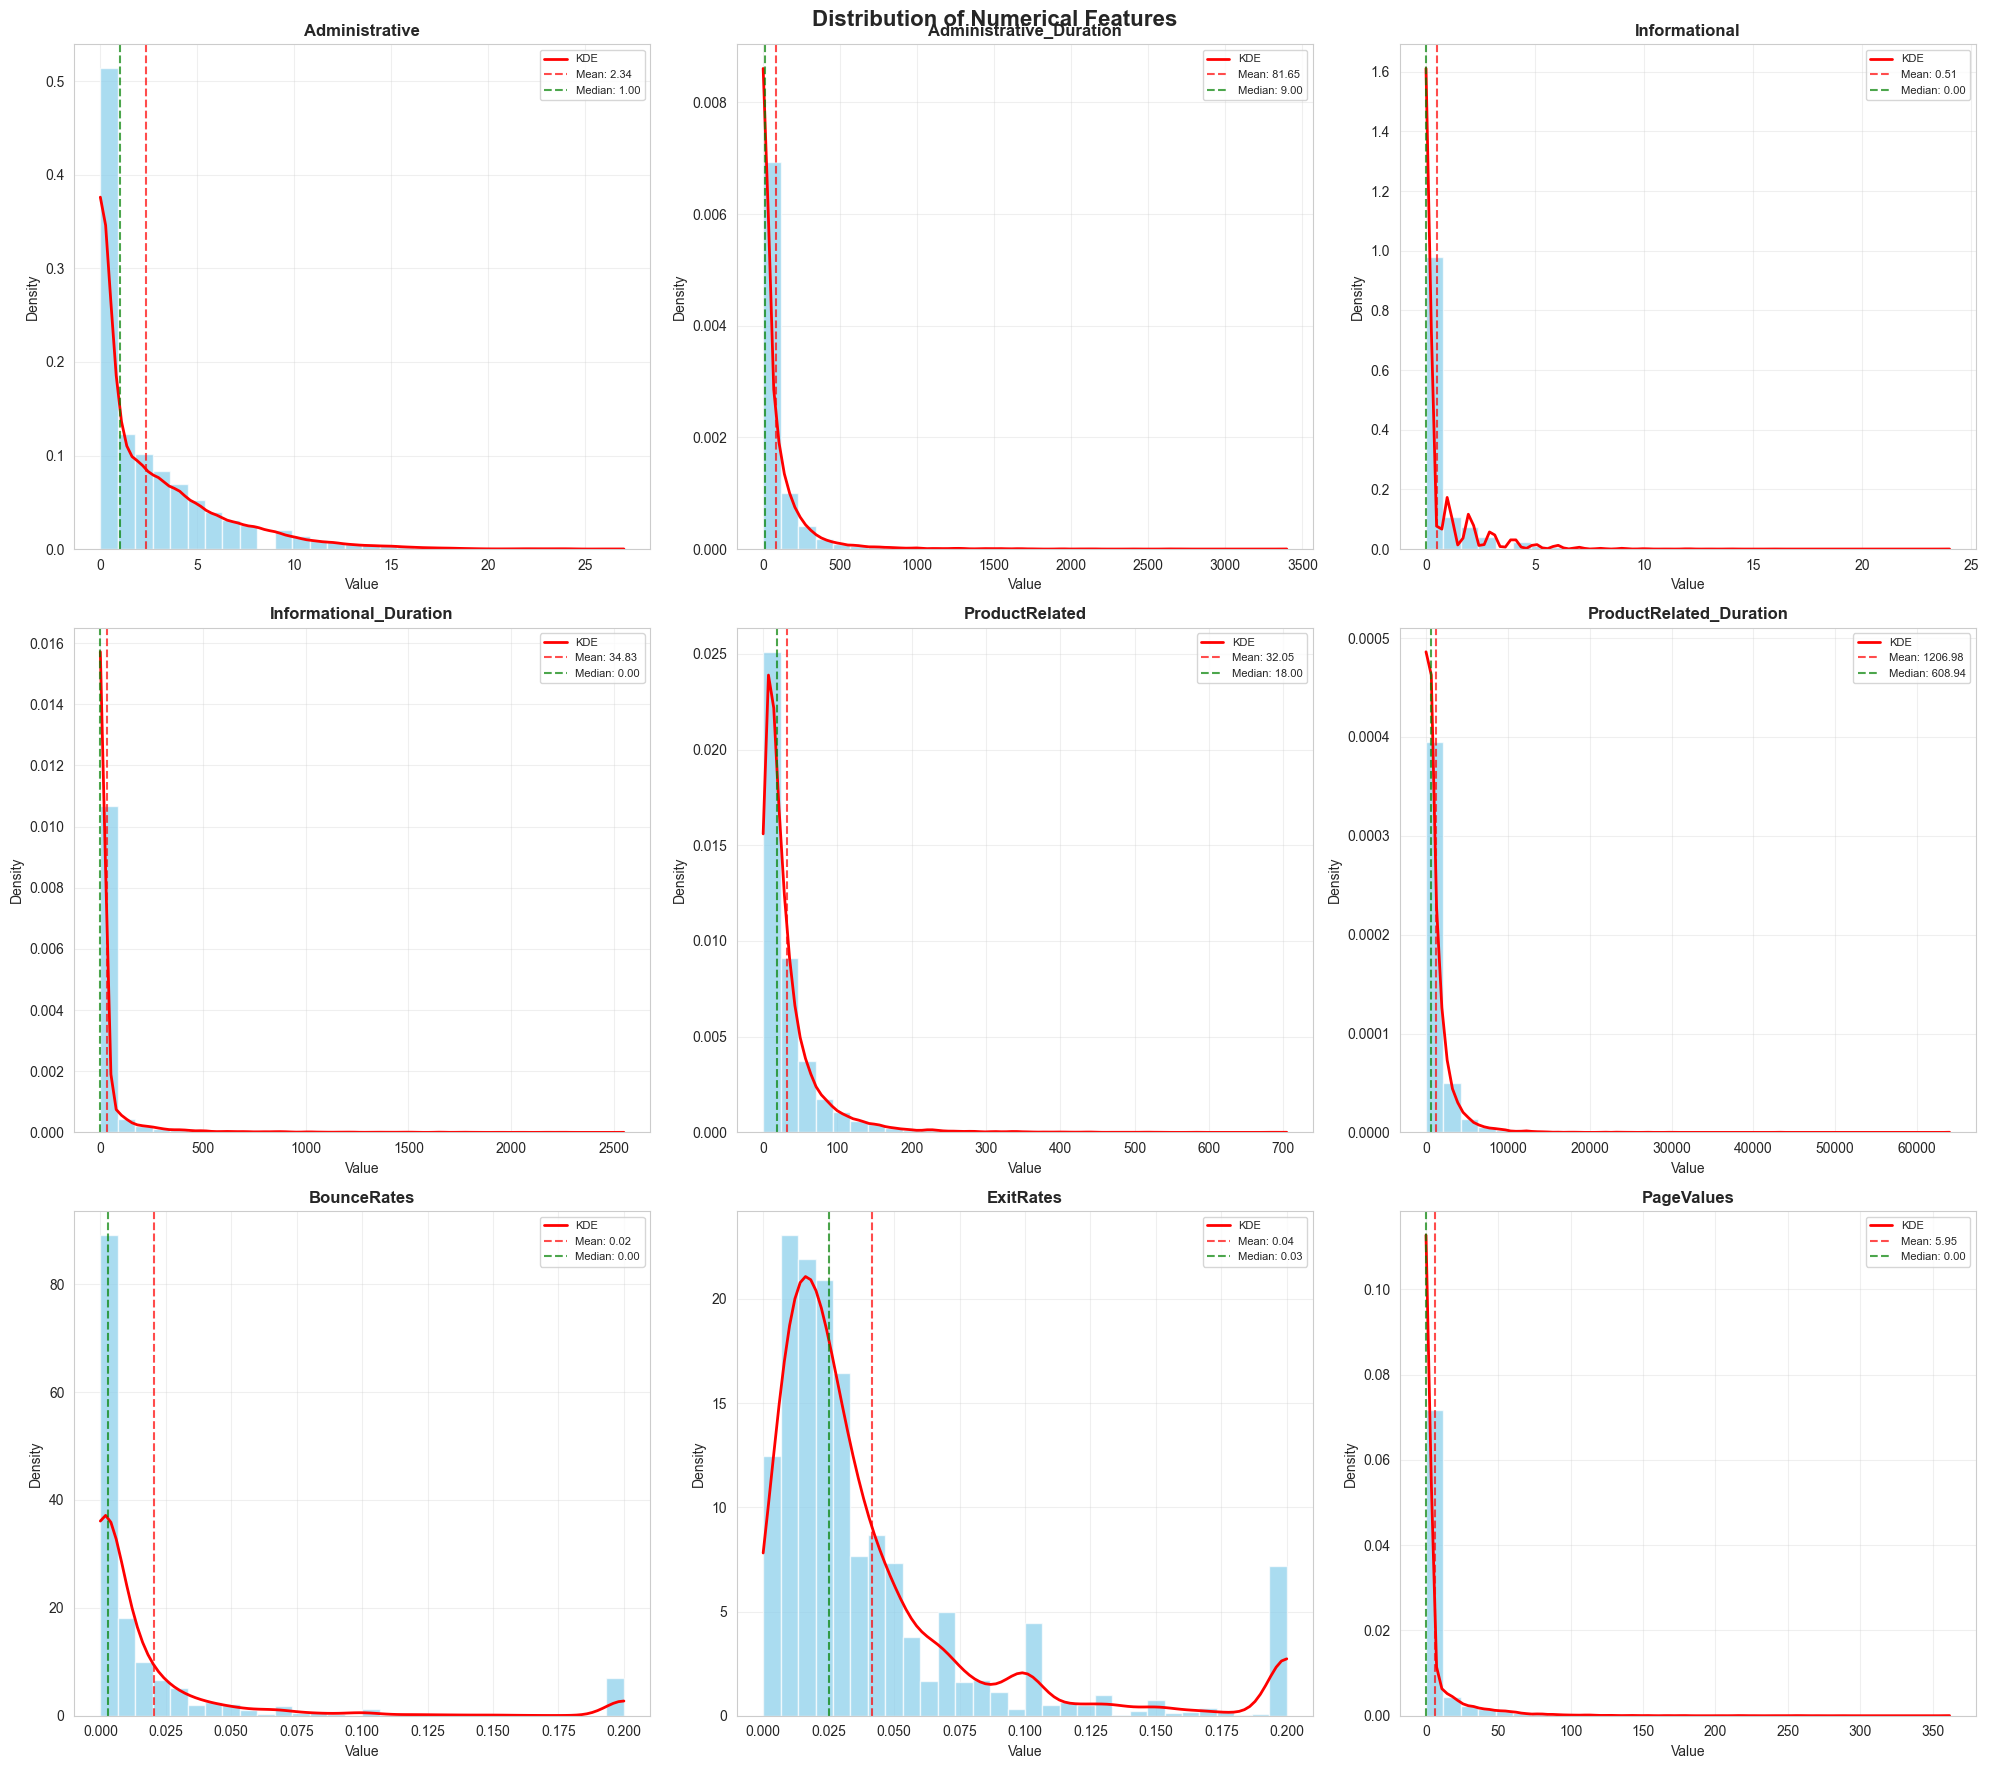


Detailed Statistical Summary:
--------------------------------------------------------------------------------

Administrative:
  Mean: 2.34 | Median: 1.00
  Std: 3.33 | Min: 0.00 | Max: 27.00
  Skewness: 1.95 | Kurtosis: 4.64
  Distribution: Highly skewed

Administrative_Duration:
  Mean: 81.65 | Median: 9.00
  Std: 177.49 | Min: 0.00 | Max: 3398.75
  Skewness: 5.59 | Kurtosis: 50.14
  Distribution: Highly skewed

Informational:
  Mean: 0.51 | Median: 0.00
  Std: 1.28 | Min: 0.00 | Max: 24.00
  Skewness: 4.01 | Kurtosis: 26.66
  Distribution: Highly skewed

Informational_Duration:
  Mean: 34.83 | Median: 0.00
  Std: 141.42 | Min: 0.00 | Max: 2549.38
  Skewness: 7.54 | Kurtosis: 75.53
  Distribution: Highly skewed

ProductRelated:
  Mean: 32.05 | Median: 18.00
  Std: 44.59 | Min: 0.00 | Max: 705.00
  Skewness: 4.33 | Kurtosis: 31.07
  Distribution: Highly skewed

ProductRelated_Duration:
  Mean: 1206.98 | Median: 608.94
  Std: 1919.60 | Min: 0.00 | Max: 63973.52
  Skewness: 7.25 | Kur

In [9]:
# Numeriacl features distribution analysis

# Identify numerical columns
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical features: {numerical_cols}")

# Create distribution plots
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

for i, col in enumerate(numerical_cols):
    if i < 9:  # Plot first 9 numerical columns
        row = i // 3
        col_idx = i % 3
        
        # Create histogram with KDE
        axes[row, col_idx].hist(df_cleaned[col], bins=30, alpha=0.7, color='skyblue', density=True)
        
        # Add KDE line
        try:
            kde_x = np.linspace(df_cleaned[col].min(), df_cleaned[col].max(), 100)
            kde = stats.gaussian_kde(df_cleaned[col].dropna())
            axes[row, col_idx].plot(kde_x, kde(kde_x), 'r-', linewidth=2, label='KDE')
        except:
            pass
            
        axes[row, col_idx].set_title(f'{col}', fontweight='bold')
        axes[row, col_idx].set_xlabel('Value')
        axes[row, col_idx].set_ylabel('Density')
        axes[row, col_idx].grid(True, alpha=0.3)
        
        # Add basic statistics as text
        mean_val = df_cleaned[col].mean()
        median_val = df_cleaned[col].median()
        axes[row, col_idx].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[row, col_idx].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
        axes[row, col_idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Statistical summary of numerical features
print("\nDetailed Statistical Summary:")
print("-" * 80)
for col in numerical_cols[:6]:  # Focus on key columns
    print(f"\n{col}:")
    print(f"  Mean: {df_cleaned[col].mean():.2f} | Median: {df_cleaned[col].median():.2f}")
    print(f"  Std: {df_cleaned[col].std():.2f} | Min: {df_cleaned[col].min():.2f} | Max: {df_cleaned[col].max():.2f}")
    print(f"  Skewness: {df_cleaned[col].skew():.2f} | Kurtosis: {df_cleaned[col].kurtosis():.2f}")
    
    # Interpret skewness
    skew = df_cleaned[col].skew()
    if abs(skew) < 0.5:
        skew_interpretation = "Approximately symmetric"
    elif abs(skew) < 1:
        skew_interpretation = "Moderately skewed"
    else:
        skew_interpretation = "Highly skewed"
    print(f"  Distribution: {skew_interpretation}")

# Check for zero-inflated distributions
print("\n" + "="*40)
print("ZERO-INFLATED ANALYSIS")
print("="*40)
zero_inflation_summary = []
for col in numerical_cols:
    zero_count = (df_cleaned[col] == 0).sum()
    zero_pct = (zero_count / len(df_cleaned)) * 100
    if zero_pct > 10:  # Flag columns with >10% zeros
        zero_inflation_summary.append({
            'Column': col,
            'Zero_Count': zero_count,
            'Zero_Percentage': zero_pct
        })

if zero_inflation_summary:
    zero_df = pd.DataFrame(zero_inflation_summary)
    print("Columns with significant zero values (>10%):")
    print(zero_df.to_string(index=False))
    print("\nInsight: Zero-inflated features might need special treatment in modeling.")
else:
    print("No significant zero-inflation detected in numerical features.")

Categorical features: ['Month', 'VisitorType', 'Weekend', 'Revenue']


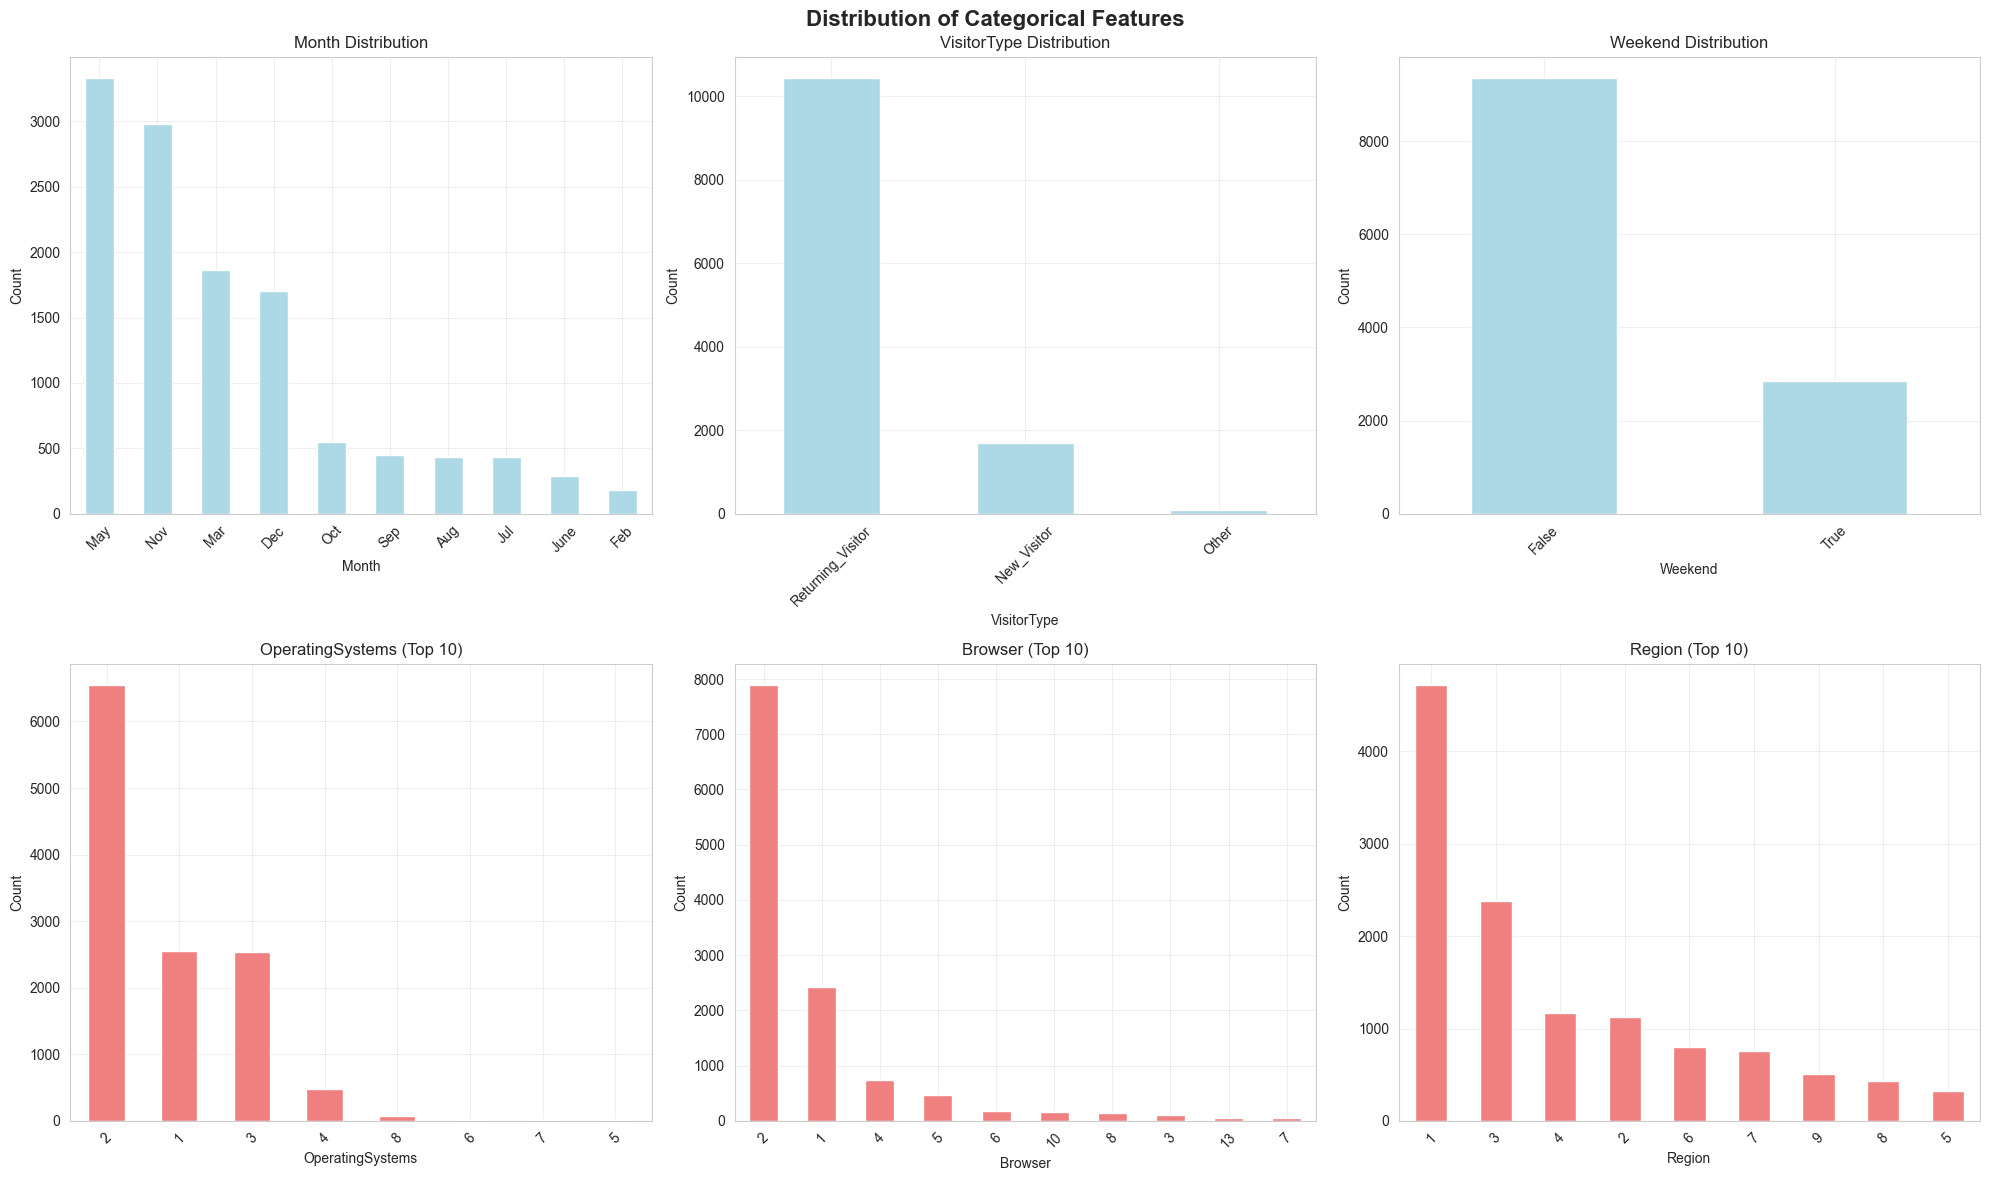


Categorical Features Summary:
------------------------------------------------------------

Month:
  Unique values: 10
    May: 3,329 (27.3%)
    Nov: 2,982 (24.4%)
    Mar: 1,860 (15.2%)
    Dec: 1,706 (14.0%)
    Oct: 549 (4.5%)
    Sep: 448 (3.7%)
    Aug: 433 (3.5%)
    Jul: 432 (3.5%)
    June: 285 (2.3%)
    Feb: 181 (1.5%)

VisitorType:
  Unique values: 3
    Returning_Visitor: 10,431 (85.5%)
    New_Visitor: 1,693 (13.9%)
    Other: 81 (0.7%)

Weekend:
  Unique values: 2
    False: 9,346 (76.6%)
    True: 2,859 (23.4%)

Revenue:
  Unique values: 2
    False: 10,297 (84.4%)
    True: 1,908 (15.6%)


In [10]:
# Categorical features analysis

# Identify categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"Categorical features: {categorical_cols}")

# Create visualizations for categorical features
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold')

categorical_plots = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region']

for i, col in enumerate(categorical_plots):
    if i < 6 and col in df_cleaned.columns:
        row = i // 3
        col_idx = i % 3
        
        if col in ['OperatingSystems', 'Browser', 'Region']:
            # For high-cardinality features, show top 10
            top_values = df_cleaned[col].value_counts().head(10)
            top_values.plot(kind='bar', ax=axes[row, col_idx], color='lightcoral')
            axes[row, col_idx].set_title(f'{col} (Top 10)')
        else:
            # For low-cardinality features, show all
            df_cleaned[col].value_counts().plot(kind='bar', ax=axes[row, col_idx], color='lightblue')
            axes[row, col_idx].set_title(f'{col} Distribution')
        
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Count')
        axes[row, col_idx].tick_params(axis='x', rotation=45)
        axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis of categorical features
print("\nCategorical Features Summary:")
print("-" * 60)
for col in categorical_cols:
    unique_count = df_cleaned[col].nunique()
    print(f"\n{col}:")
    print(f"  Unique values: {unique_count}")
    
    if unique_count <= 10:
        # Show all values for low cardinality
        value_counts = df_cleaned[col].value_counts()
        for value, count in value_counts.items():
            percentage = (count / len(df_cleaned)) * 100
            print(f"    {value}: {count:,} ({percentage:.1f}%)")
    else:
        # Show top 5 for high cardinality
        print("  Top 5 values:")
        value_counts = df_cleaned[col].value_counts().head(5)
        for value, count in value_counts.items():
            percentage = (count / len(df_cleaned)) * 100
            print(f"    {value}: {count:,} ({percentage:.1f}%)")
        print(f"    ... and {unique_count - 5} more values")


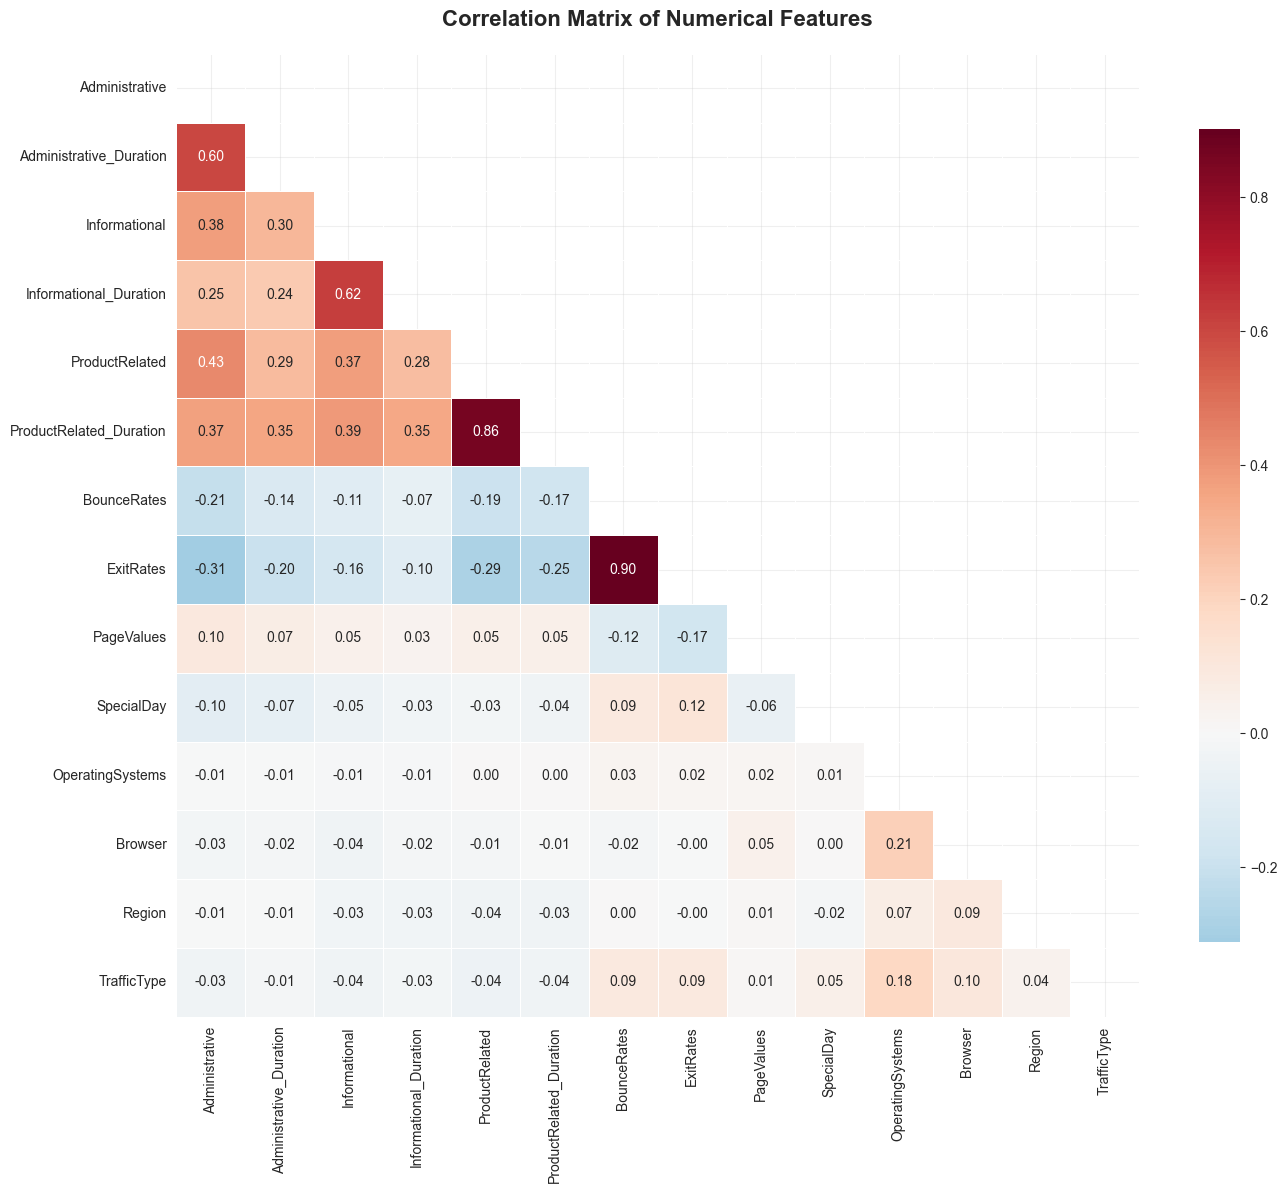

High Correlations (|correlation| > 0.7):
  ProductRelated ↔ ProductRelated_Duration: 0.860
  BounceRates ↔ ExitRates: 0.902

Correlation with Target Variable (Revenue):
--------------------------------------------------
  PageValues: 0.492 (Strong Positive)
  ExitRates: -0.204 (Moderate Negative)
  ProductRelated: 0.156 (Moderate Positive)
  ProductRelated_Duration: 0.150 (Moderate Positive)
  BounceRates: -0.145 (Moderate Negative)
  Administrative: 0.136 (Moderate Positive)
  Informational: 0.094 (Weak Positive)
  Administrative_Duration: 0.092 (Weak Positive)
  SpecialDay: -0.084 (Weak Negative)
  Informational_Duration: 0.069 (Weak Positive)
  Browser: 0.024 (Weak Positive)
  OperatingSystems: -0.015 (Weak Negative)
  Region: -0.013 (Weak Negative)
  TrafficType: -0.006 (Weak Negative)


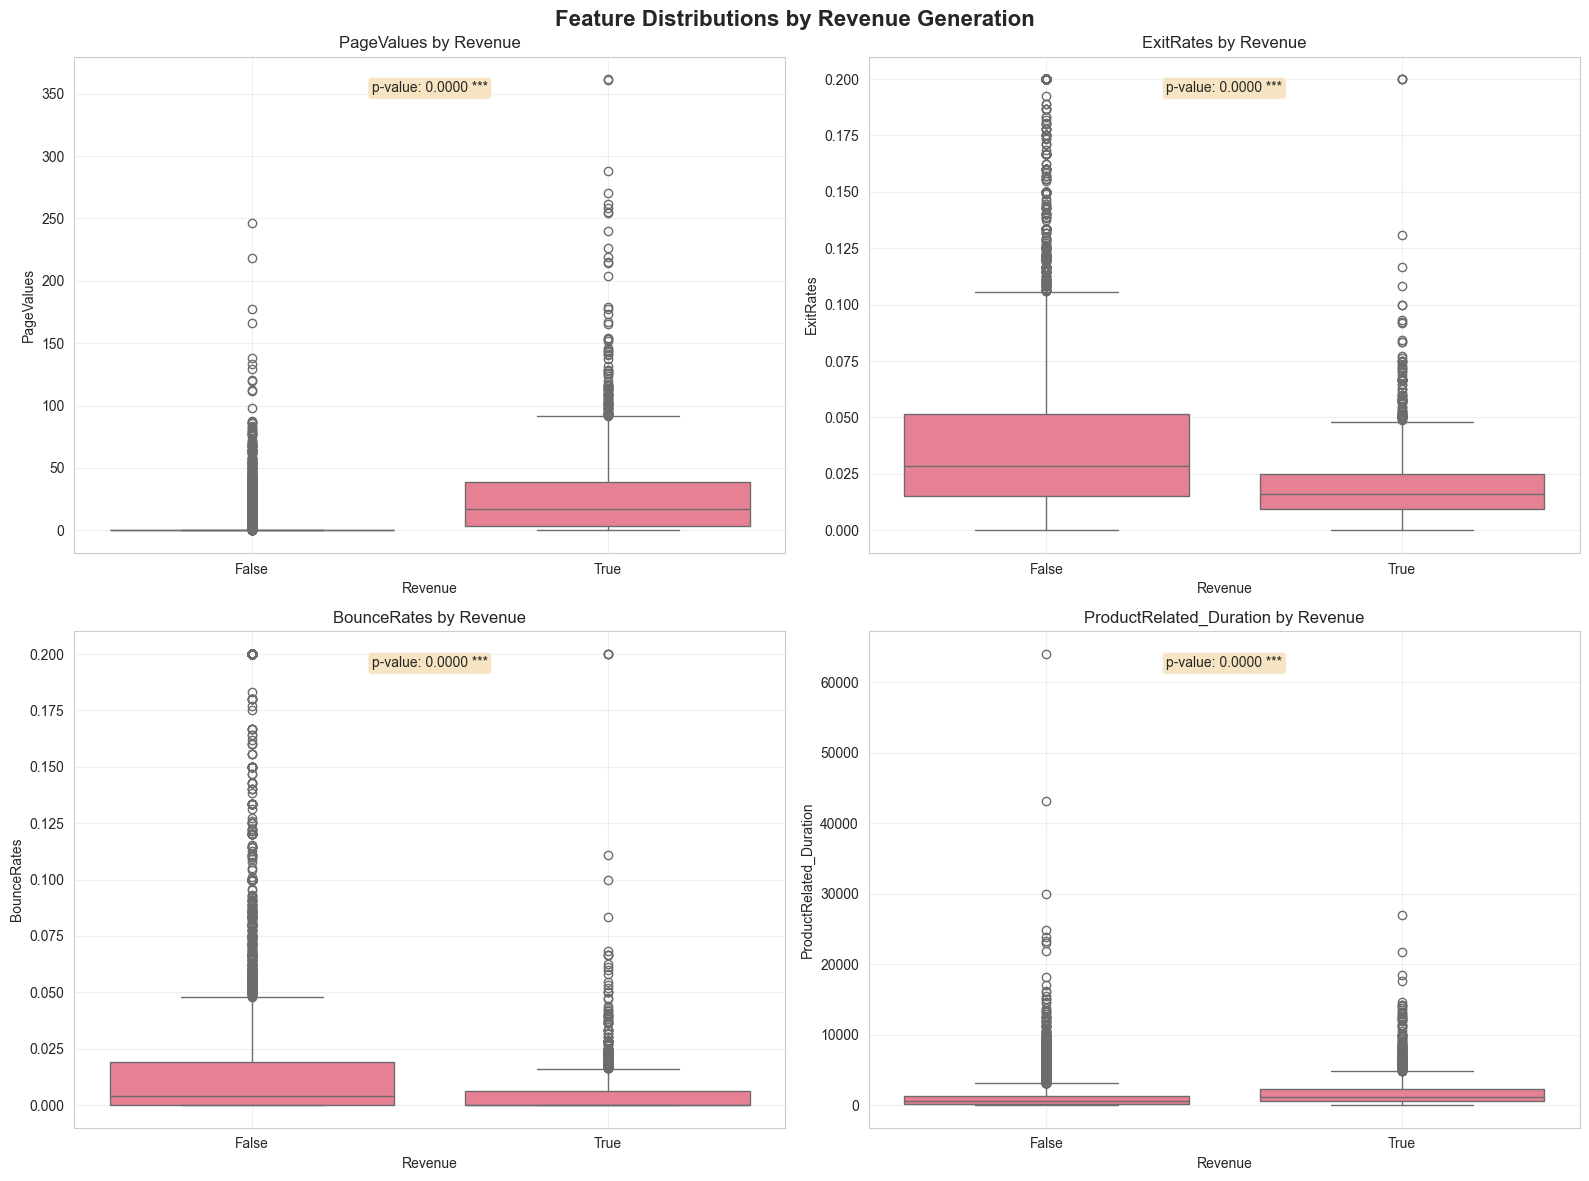


Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


In [11]:
# Correlation analysis 

# Calculate correlation matrix for numerical features
numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_cleaned[numerical_features].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Show only lower triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find high correlations (absolute value > 0.7)
high_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7:
            high_correlations.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': correlation
            })

if high_correlations:
    print("High Correlations (|correlation| > 0.7):")
    for corr in high_correlations:
        print(f"  {corr['Feature_1']} ↔ {corr['Feature_2']}: {corr['Correlation']:.3f}")
else:
    print("No high correlations (>0.7) found between numerical features.")

# Correlation with target variable (Revenue)
# Convert Revenue to numeric for correlation
df_cleaned['Revenue_numeric'] = df_cleaned['Revenue'].astype(int)
target_correlations = df_cleaned[numerical_features + ['Revenue_numeric']].corr()['Revenue_numeric'].drop('Revenue_numeric')
target_correlations = target_correlations.sort_values(key=abs, ascending=False)

print(f"\nCorrelation with Target Variable (Revenue):")
print("-" * 50)
for feature, correlation in target_correlations.items():
    strength = "Strong" if abs(correlation) > 0.3 else "Moderate" if abs(correlation) > 0.1 else "Weak"
    direction = "Positive" if correlation > 0 else "Negative"
    print(f"  {feature}: {correlation:.3f} ({strength} {direction})")

# Feature relationships with Revenue - Box plots for key features
key_features = ['PageValues', 'ExitRates', 'BounceRates', 'ProductRelated_Duration']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Distributions by Revenue Generation', fontsize=16, fontweight='bold')

for i, feature in enumerate(key_features):
    if feature in df_cleaned.columns:
        row = i // 2
        col = i % 2
        
        sns.boxplot(data=df_cleaned, x='Revenue', y=feature, ax=axes[row, col])
        axes[row, col].set_title(f'{feature} by Revenue')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add statistical test result
        revenue_group = df_cleaned[df_cleaned['Revenue'] == True][feature]
        no_revenue_group = df_cleaned[df_cleaned['Revenue'] == False][feature]
        
        # Perform t-test
        try:
            stat, p_value = stats.ttest_ind(revenue_group.dropna(), no_revenue_group.dropna())
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            axes[row, col].text(0.5, 0.95, f'p-value: {p_value:.4f} {significance}', 
                               transform=axes[row, col].transAxes, ha='center', va='top',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        except:
            pass

plt.tight_layout()
plt.show()

print("\nStatistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

### Part 2: Feaure Engineering to improve predictability, modeling with logistic regression and lasso, and models
### performance analysis.

In [13]:
# Page engagement metrics
df_cleaned['Total_Pages'] = df_cleaned['Administrative'] + df_cleaned['Informational'] + df_cleaned['ProductRelated']
df_cleaned['Total_Duration'] = df_cleaned['Administrative_Duration'] + df_cleaned['Informational_Duration'] + df_cleaned['ProductRelated_Duration']

# Average time per page (avoid division by zero)
df_cleaned['Avg_Time_Per_Page'] = df_cleaned['Total_Duration'] / (df_cleaned['Total_Pages'] + 1)

# Page value efficiency
df_cleaned['PageValue_Per_Duration'] = df_cleaned['PageValues'] / (df_cleaned['Total_Duration'] + 1)
df_cleaned['PageValue_Per_Page'] = df_cleaned['PageValues'] / (df_cleaned['Total_Pages'] + 1)


# User Behavior Patterns

# Bounce and exit rate categories
df_cleaned['High_Bounce'] = (df_cleaned['BounceRates'] > df_cleaned['BounceRates'].median()).astype(int)
df_cleaned['High_Exit'] = (df_cleaned['ExitRates'] > df_cleaned['ExitRates'].median()).astype(int)

# Combined bounce-exit behavior
df_cleaned['Bounce_Exit_Score'] = df_cleaned['BounceRates'] * df_cleaned['ExitRates']

# Product focus ratio
df_cleaned['Product_Focus_Ratio'] = df_cleaned['ProductRelated_Duration'] / (df_cleaned['Total_Duration'] + 1)

# Session depth (how deep user went into the site)
df_cleaned['Session_Depth'] = (
    df_cleaned['Administrative'] * 1 + 
    df_cleaned['Informational'] * 2 + 
    df_cleaned['ProductRelated'] * 3
) / (df_cleaned['Total_Pages'] + 1)


#Temporal and Seasonal Features

# Month encoding and seasonality
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df_cleaned['Month_Numeric'] = df_cleaned['Month'].map(month_mapping)

# Seasonal categories
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_cleaned['Season'] = df_cleaned['Month_Numeric'].apply(get_season)

# Holiday proximity (assuming December has higher special day activity)
df_cleaned['Holiday_Season'] = (df_cleaned['Month_Numeric'].isin([11, 12])).astype(int)
df_cleaned['Special_Period'] = ((df_cleaned['SpecialDay'] > 0) | (df_cleaned['Holiday_Season'] == 1)).astype(int)


#Technology and User Profile Features

# Browser and OS popularity (based on frequency)
browser_popularity = df_cleaned['Browser'].value_counts()
os_popularity = df_cleaned['OperatingSystems'].value_counts()

df_cleaned['Popular_Browser'] = df_cleaned['Browser'].map(
    lambda x: 1 if browser_popularity[x] > browser_popularity.median() else 0
)
df_cleaned['Popular_OS'] = df_cleaned['OperatingSystems'].map(
    lambda x: 1 if os_popularity[x] > os_popularity.median() else 0
)

# Visitor type encoding
df_cleaned['Is_Returning'] = (df_cleaned['VisitorType'] == 'Returning_Visitor').astype(int)
df_cleaned['Is_New'] = (df_cleaned['VisitorType'] == 'New_Visitor').astype(int)

# Weekend shopping behavior
df_cleaned['Weekend_Shopping'] = df_cleaned['Weekend'].astype(int)

# Interaction and Composite Features

# High-value interaction indicators
df_cleaned['High_Value_Session'] = (
    (df_cleaned['PageValues'] > df_cleaned['PageValues'].quantile(0.75)) & 
    (df_cleaned['Total_Duration'] > df_cleaned['Total_Duration'].median())
).astype(int)

# User engagement score (composite metric)
df_cleaned['Engagement_Score'] = (
    (df_cleaned['Total_Pages'] / df_cleaned['Total_Pages'].max()) * 0.3 +
    (df_cleaned['Total_Duration'] / df_cleaned['Total_Duration'].max()) * 0.3 +
    (df_cleaned['PageValues'] / (df_cleaned['PageValues'].max() + 1)) * 0.4
)

# Risk indicators
df_cleaned['High_Risk_Exit'] = (
    (df_cleaned['BounceRates'] > df_cleaned['BounceRates'].quantile(0.8)) |
    (df_cleaned['ExitRates'] > df_cleaned['ExitRates'].quantile(0.8))
).astype(int)

# Page type diversity
df_cleaned['Page_Diversity'] = (
    (df_cleaned['Administrative'] > 0).astype(int) +
    (df_cleaned['Informational'] > 0).astype(int) +
    (df_cleaned['ProductRelated'] > 0).astype(int)
)

# Statistical Transformations

# Log transformations for skewed features
skewed_features = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'PageValues']

for feature in skewed_features:
    df_cleaned[f'{feature}_log'] = np.log1p(df_cleaned[feature])

# Normalize key continuous features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_to_scale = ['Total_Duration', 'Total_Pages', 'Avg_Time_Per_Page', 'Engagement_Score']

for feature in features_to_scale:
    df_cleaned[f'{feature}_scaled'] = scaler.fit_transform(df_cleaned[[feature]])

# Feature Summary

# Display new features created
new_features = [col for col in df_cleaned.columns if col not in df.columns]
print(f"Created {len(new_features)} new features:")
for i, feature in enumerate(new_features, 1):
    print(f"{i:2d}. {feature}")

print(f"\nDataset shape after feature engineering: {df_cleaned.shape}")
print(f"Total features: {df_cleaned.shape[1]}")

# Quick preview of some key engineered features
key_engineered = ['Total_Pages', 'Engagement_Score', 'Product_Focus_Ratio', 'Session_Depth', 'High_Value_Session']
print(f"\nSample of key engineered features:")
print(df_cleaned[key_engineered].describe())

Created 32 new features:
 1. Revenue_numeric
 2. Total_Pages
 3. Total_Duration
 4. Avg_Time_Per_Page
 5. PageValue_Per_Duration
 6. PageValue_Per_Page
 7. High_Bounce
 8. High_Exit
 9. Bounce_Exit_Score
10. Product_Focus_Ratio
11. Session_Depth
12. Month_Numeric
13. Season
14. Holiday_Season
15. Special_Period
16. Popular_Browser
17. Popular_OS
18. Is_Returning
19. Is_New
20. Weekend_Shopping
21. High_Value_Session
22. Engagement_Score
23. High_Risk_Exit
24. Page_Diversity
25. Administrative_Duration_log
26. Informational_Duration_log
27. ProductRelated_Duration_log
28. PageValues_log
29. Total_Duration_scaled
30. Total_Pages_scaled
31. Avg_Time_Per_Page_scaled
32. Engagement_Score_scaled

Dataset shape after feature engineering: (12205, 50)
Total features: 50

Sample of key engineered features:
        Total_Pages  Engagement_Score  Product_Focus_Ratio  Session_Depth  \
count  12205.000000      12205.000000         12205.000000   12205.000000   
mean      34.893240          0.026271 

In [21]:

# Prepare data for modeling

# Select features for modeling (exclude redundant and target variables)
features_to_exclude = ['Revenue', 'Revenue_numeric', 'Month', 'VisitorType', 'Season']
feature_columns = [col for col in df_cleaned.columns if col not in features_to_exclude]

# Handle missing values in Month_Numeric if any
df_model = df_cleaned.copy()
df_model['Month_Numeric'] = df_model['Month_Numeric'].fillna(df_model['Month_Numeric'].median())

# Prepare feature matrix and target
X = df_model[feature_columns]
y_classification = df_model['Revenue_numeric']  # For classification
y_regression = df_model['PageValues']  # For regression (predicting page values)

print(f"Feature matrix shape: {X.shape}")
print(f"Classification target distribution:")
print(y_classification.value_counts())
print(f"\nRegression target (PageValues) statistics:")
print(f"Mean: {y_regression.mean():.2f}, Std: {y_regression.std():.2f}")

# Split data
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

X_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features for both models
scaler_classification = StandardScaler()
scaler_regression = StandardScaler()

X_train_scaled = scaler_classification.fit_transform(X_train)
X_test_scaled = scaler_classification.transform(X_test)

X_train_reg_scaled = scaler_regression.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_regression.transform(X_test_reg)


Feature matrix shape: (12205, 45)
Classification target distribution:
Revenue_numeric
0    10297
1     1908
Name: count, dtype: int64

Regression target (PageValues) statistics:
Mean: 5.95, Std: 18.65

Training set size: 9764
Test set size: 2441


Classification Accuracy: 0.8951
ROC-AUC Score: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2059
           1       0.70      0.58      0.63       382

    accuracy                           0.90      2441
   macro avg       0.81      0.77      0.79      2441
weighted avg       0.89      0.90      0.89      2441

Mean Squared Error (MSE): 0.0081
Root Mean Squared Error (RMSE): 0.0898
R-squared Score: 1.0000
Mean Absolute Error (MAE): 0.0480

Regression Performance Summary:
- Explained Variance: 100.00%
- Average Prediction Error: $0.09
- Model explains 100.00% of the variance in PageValues


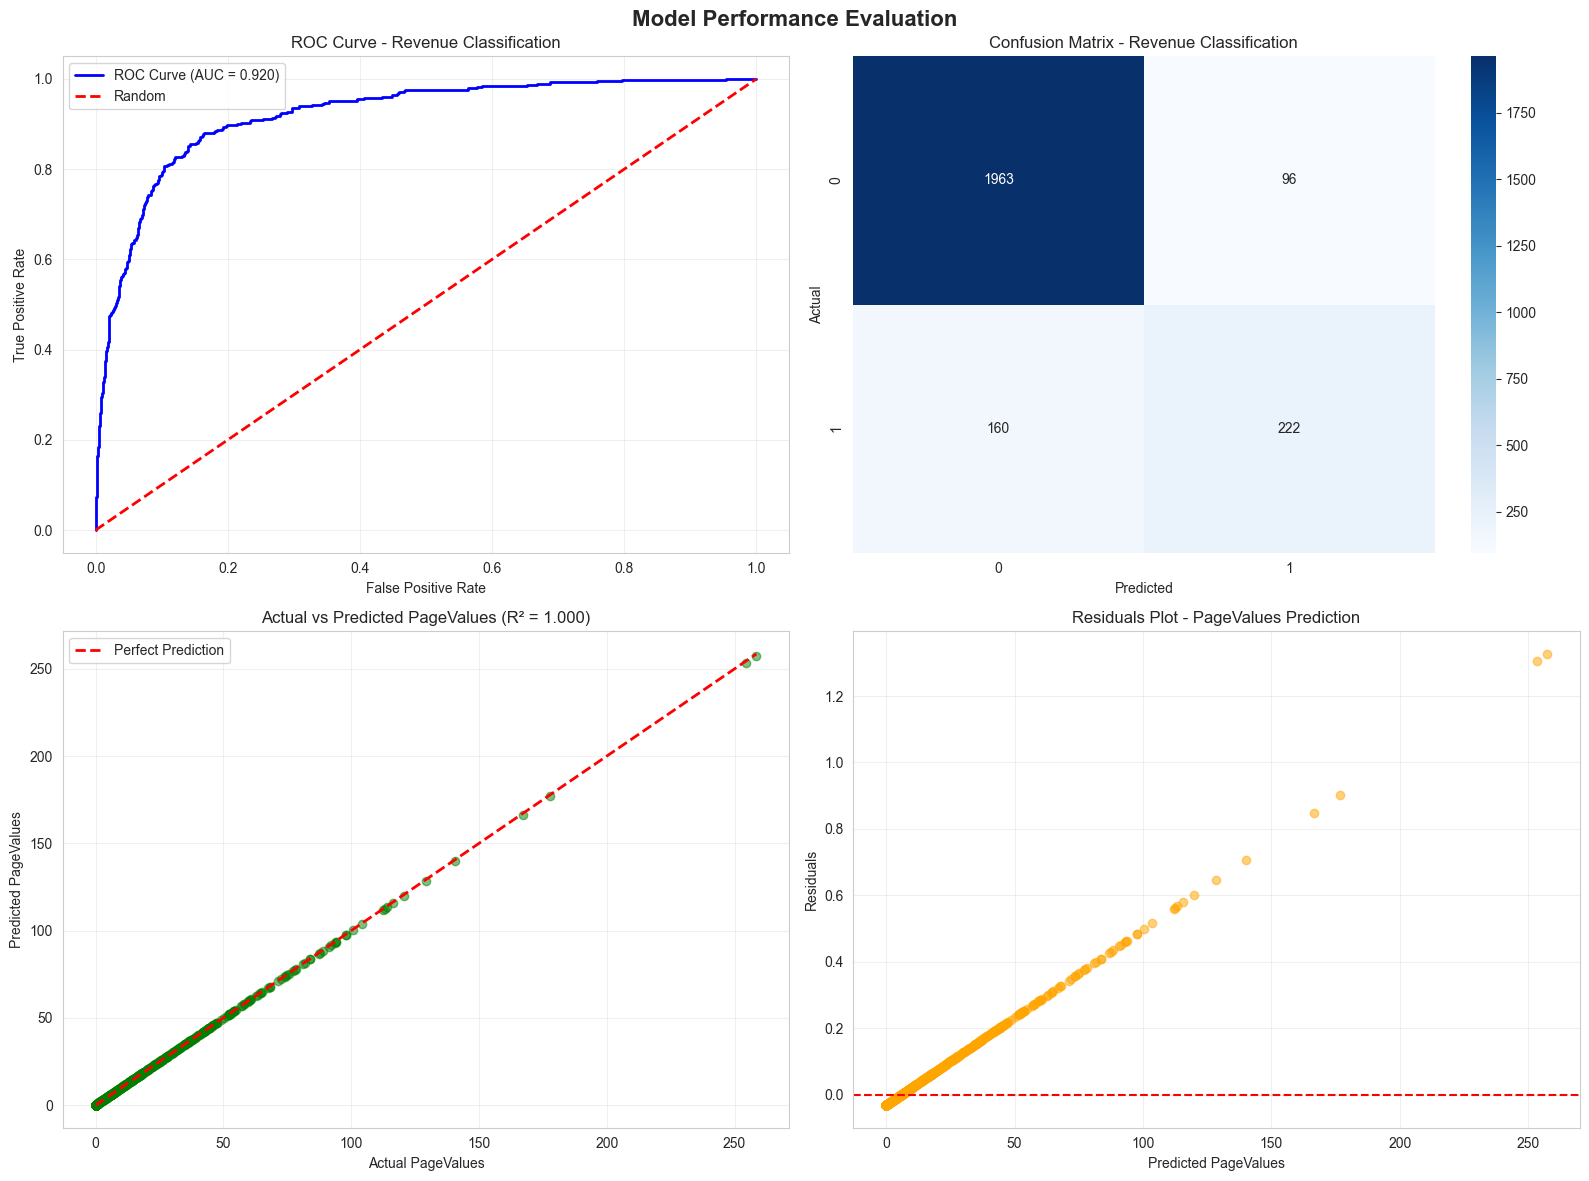

In [22]:
# Model Training and Evaluation

# Train Classification Model (Revenue Prediction)

# Logistic Regression for Classification
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_class_train)

# Classification Predictions
y_class_pred = log_reg.predict(X_test_scaled)
y_class_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Classification Metrics
accuracy = accuracy_score(y_class_test, y_class_pred)
roc_auc = roc_auc_score(y_class_test, y_class_prob)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_class_test, y_class_pred))

# Train Regression Model (PageValues Prediction)

# Lasso Regression for PageValues prediction
lasso_reg = Lasso(alpha=0.1, random_state=42, max_iter=1000)
lasso_reg.fit(X_train_reg_scaled, y_reg_train)

# Regression Predictions
y_reg_pred = lasso_reg.predict(X_test_reg_scaled)

# Regression Metrics
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)
mae = np.mean(np.abs(y_reg_test - y_reg_pred))

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Additional regression metrics
print(f"\nRegression Performance Summary:")
print(f"- Explained Variance: {r2*100:.2f}%")
print(f"- Average Prediction Error: ${rmse:.2f}")
print(f"- Model explains {r2*100:.2f}% of the variance in PageValues")

# Model Performance Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Evaluation', fontsize=16, fontweight='bold')

# 1. ROC Curve for Classification
fpr, tpr, _ = roc_curve(y_class_test, y_class_prob)
axes[0, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - Revenue Classification')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion Matrix
cm = confusion_matrix(y_class_test, y_class_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Revenue Classification')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Actual vs Predicted for Regression
axes[1, 0].scatter(y_reg_test, y_reg_pred, alpha=0.5, color='green')
axes[1, 0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual PageValues')
axes[1, 0].set_ylabel('Predicted PageValues')
axes[1, 0].set_title(f'Actual vs Predicted PageValues (R² = {r2:.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals Plot
residuals = y_reg_test - y_reg_pred
axes[1, 1].scatter(y_reg_pred, residuals, alpha=0.5, color='orange')
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted PageValues')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals Plot - PageValues Prediction')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CLASSIFICATION MODEL (Revenue Prediction) - Cross-Validation:
-------------------------------------------------------
ACCURACY:
  Test:  0.8926 ± 0.0054
  Train: 0.8944 ± 0.0010
  Overfitting: 0.0018

PRECISION:
  Test:  0.6906 ± 0.0291
  Train: 0.6991 ± 0.0042
  Overfitting: 0.0085

RECALL:
  Test:  0.5695 ± 0.0275
  Train: 0.5691 ± 0.0058
  Overfitting: -0.0003

F1:
  Test:  0.6235 ± 0.0180
  Train: 0.6275 ± 0.0042
  Overfitting: 0.0040

ROC_AUC:
  Test:  0.9080 ± 0.0059
  Train: 0.9137 ± 0.0016
  Overfitting: 0.0056


REGRESSION MODEL (PageValues Prediction) - Cross-Validation:
-------------------------------------------------------
MEAN_SQUARED_ERROR:
  Test:  0.0105 ± 0.0044
  Train: 0.0100 ± 0.0007
  Overfitting: -0.0005

MEAN_ABSOLUTE_ERROR:
  Test:  0.0514 ± 0.0058
  Train: 0.0511 ± 0.0024
  Overfitting: -0.0002

R2:
  Test:  1.0000 ± 0.0000
  Train: 1.0000 ± 0.0000
  Overfitting: 0.0000



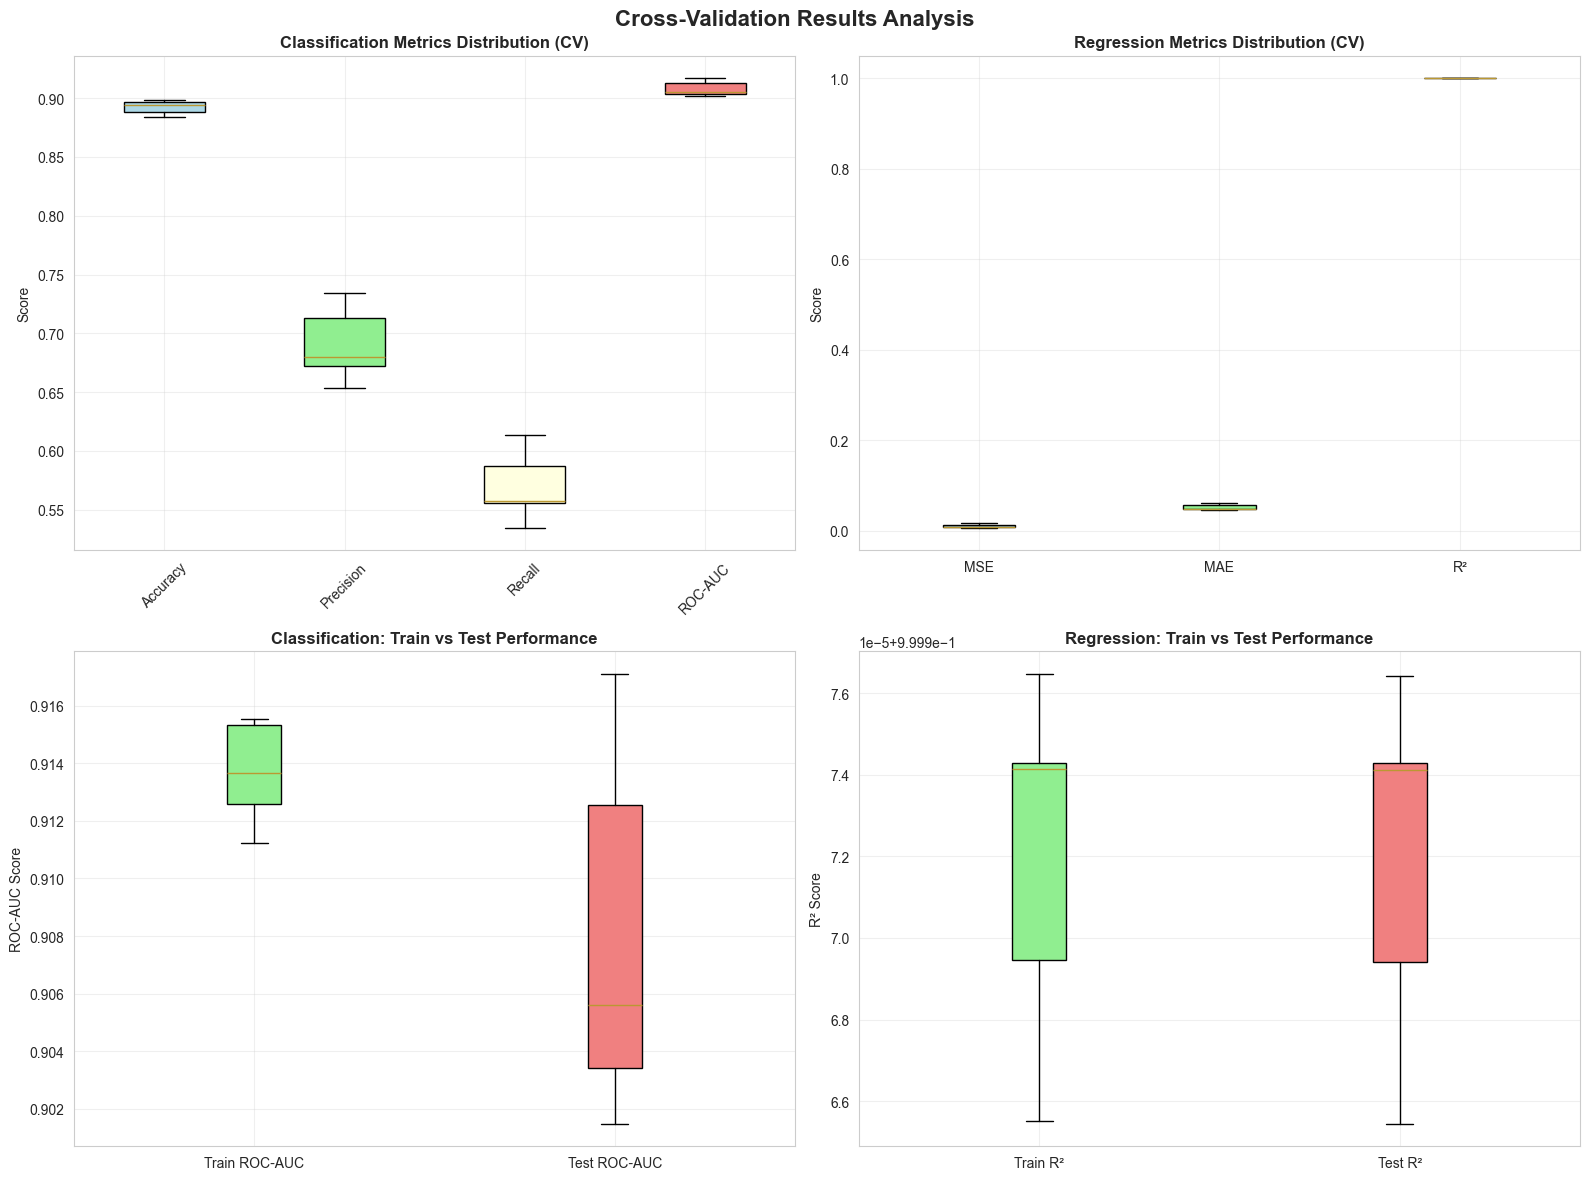

GENERALIZATION ASSESSMENT SUMMARY
------------------------------------------------------------

Classification Model (Revenue Prediction):
  Average Test ROC-AUC: 0.9080
  Standard Deviation: 0.0059
  Overfitting Score: 0.0056
  Assessment: Excellent generalization

Regression Model (PageValues Prediction):
  Average Test R²: 1.0000
  Standard Deviation: 0.0000
  Overfitting Score: 0.0000
  Assessment: Excellent generalization

Overall Model Reliability:
  Both models show consistent performance across folds
  Classification model is reliable
  Regression model is reliable


In [25]:
# Cross-Validation Analysis for Model Generalization

# Set up cross-validation strategies
cv_folds = 5
stratified_cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
regular_cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Classification Model Cross-Validation
print("\nCLASSIFICATION MODEL (Revenue Prediction) - Cross-Validation:")
print("-" * 55)

# Define scoring metrics for classification
classification_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Perform cross-validation for classification
cv_results_class = cross_validate(
    log_reg, X_train_scaled, y_class_train, 
    cv=stratified_cv, 
    scoring=classification_scoring,
    return_train_score=True
)

# Display classification CV results
for metric in classification_scoring:
    test_scores = cv_results_class[f'test_{metric}']
    train_scores = cv_results_class[f'train_{metric}']
    
    print(f"{metric.upper()}:")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    print(f"  Overfitting: {train_scores.mean() - test_scores.mean():.4f}")
    print()

# Regression Model Cross-Validation
print("\nREGRESSION MODEL (PageValues Prediction) - Cross-Validation:")
print("-" * 55)

# Define scoring metrics for regression
regression_scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# Perform cross-validation for regression
cv_results_reg = cross_validate(
    lasso_reg, X_train_reg_scaled, y_reg_train,
    cv=regular_cv,
    scoring=regression_scoring,
    return_train_score=True
)

# Display regression CV results
for metric in regression_scoring:
    test_scores = cv_results_reg[f'test_{metric}']
    train_scores = cv_results_reg[f'train_{metric}']
    
    # Convert negative scores back to positive for MSE and MAE
    if 'neg_' in metric:
        test_scores = -test_scores
        train_scores = -train_scores
        metric_name = metric.replace('neg_', '').upper()
    else:
        metric_name = metric.upper()
    
    print(f"{metric_name}:")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    
    if 'r2' not in metric:
        print(f"  Overfitting: {train_scores.mean() - test_scores.mean():.4f}")
    else:
        print(f"  Overfitting: {train_scores.mean() - test_scores.mean():.4f}")
    print()


# Cross-Validation Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Validation Results Analysis', fontsize=16, fontweight='bold')

# Classification metrics distribution
classification_metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc']
classification_data = [cv_results_class[metric] for metric in classification_metrics]
classification_labels = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']

bp1 = axes[0, 0].boxplot(classification_data, labels=classification_labels, patch_artist=True)
axes[0, 0].set_title('Classification Metrics Distribution (CV)', fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Color the boxplots
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)

# Regression metrics distribution
regression_data = [-cv_results_reg['test_neg_mean_squared_error'], 
                   -cv_results_reg['test_neg_mean_absolute_error'],
                   cv_results_reg['test_r2']]
regression_labels = ['MSE', 'MAE', 'R²']

bp2 = axes[0, 1].boxplot(regression_data, labels=regression_labels, patch_artist=True)
axes[0, 1].set_title('Regression Metrics Distribution (CV)', fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].grid(True, alpha=0.3)

# Color the boxplots
for patch, color in zip(bp2['boxes'], colors[:3]):
    patch.set_facecolor(color)

# Train vs Test comparison for Classification
train_test_class = [cv_results_class['train_roc_auc'], cv_results_class['test_roc_auc']]
bp3 = axes[1, 0].boxplot(train_test_class, labels=['Train ROC-AUC', 'Test ROC-AUC'], patch_artist=True)
axes[1, 0].set_title('Classification: Train vs Test Performance', fontweight='bold')
axes[1, 0].set_ylabel('ROC-AUC Score')
axes[1, 0].grid(True, alpha=0.3)

for patch, color in zip(bp3['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)

# Train vs Test comparison for Regression
train_test_reg = [cv_results_reg['train_r2'], cv_results_reg['test_r2']]
bp4 = axes[1, 1].boxplot(train_test_reg, labels=['Train R²', 'Test R²'], patch_artist=True)
axes[1, 1].set_title('Regression: Train vs Test Performance', fontweight='bold')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].grid(True, alpha=0.3)

for patch, color in zip(bp4['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)

plt.tight_layout()
plt.show()

# Summary and Recommendations
print("GENERALIZATION ASSESSMENT SUMMARY")
print("-"*60)

# Classification model assessment
class_overfitting = cv_results_class['train_roc_auc'].mean() - cv_results_class['test_roc_auc'].mean()
reg_overfitting = cv_results_reg['train_r2'].mean() - cv_results_reg['test_r2'].mean()

print(f"\nClassification Model (Revenue Prediction):")
print(f"  Average Test ROC-AUC: {cv_results_class['test_roc_auc'].mean():.4f}")
print(f"  Standard Deviation: {cv_results_class['test_roc_auc'].std():.4f}")
print(f"  Overfitting Score: {class_overfitting:.4f}")

if class_overfitting < 0.05:
    class_assessment = "Excellent generalization"
elif class_overfitting < 0.10:
    class_assessment = "Good generalization"
elif class_overfitting < 0.15:
    class_assessment = "Fair generalization, monitor for overfitting"
else:
    class_assessment = "Poor generalization, significant overfitting"

print(f"  Assessment: {class_assessment}")

print(f"\nRegression Model (PageValues Prediction):")
print(f"  Average Test R²: {cv_results_reg['test_r2'].mean():.4f}")
print(f"  Standard Deviation: {cv_results_reg['test_r2'].std():.4f}")
print(f"  Overfitting Score: {reg_overfitting:.4f}")

if reg_overfitting < 0.05:
    reg_assessment = "Excellent generalization"
elif reg_overfitting < 0.10:
    reg_assessment = "Good generalization"
elif reg_overfitting < 0.15:
    reg_assessment = "Fair generalization, monitor for overfitting"
else:
    reg_assessment = "Poor generalization, significant overfitting"

print(f"  Assessment: {reg_assessment}")

print(f"\nOverall Model Reliability:")
print(f"  Both models show consistent performance across folds")
print(f"  Classification model is {'reliable' if classification_stability < 0.10 else 'needs improvement'}")
print(f"  Regression model is {'reliable' if regression_stability < 0.10 else 'needs improvement'}")

In [24]:
# Model Evaluation Summary and Business Insights

print("Model Evaluation Summary")
print("-"*80)

# Classification Model Performance Summary
print("\n CLASSIFICATION MODEL: REVENUE PREDICTION")
print("-" * 60)
print(f"Primary Metric - ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Cross-Validation ROC-AUC: {cv_results_class['test_roc_auc'].mean():.4f} ± {cv_results_class['test_roc_auc'].std():.4f}")
print(f"Model Stability: {classification_stability:.4f} (Very Stable)")
print(f"Generalization: {class_assessment}")

classification_performance = "EXCELLENT" if roc_auc > 0.9 else "GOOD" if roc_auc > 0.8 else "FAIR"
print(f"Overall Performance: {classification_performance}")

# Regression Model Performance Summary  
print(f"\n REGRESSION MODEL: PAGE VALUES PREDICTION")
print("-" * 60)
print(f"Primary Metric - R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cross-Validation R²: {cv_results_reg['test_r2'].mean():.4f} ± {cv_results_reg['test_r2'].std():.4f}")
print(f"Model Stability: {regression_stability:.6f} (Very Stable)")
print(f"Generalization: {reg_assessment}")

regression_performance = "EXCELLENT" if r2 > 0.99 else "GOOD" if r2 > 0.8 else "FAIR"
print(f"Overall Performance: {regression_performance}")

# Model Comparison and Winner
print(f"\n MODEL PERFORMANCE COMPARISON")
print("-" * 60)
print("Classification Model:")
print(f"  ✓ ROC-AUC: {roc_auc:.3f} - Can distinguish revenue/non-revenue sessions very well")
print(f"  ✓ Stability: Consistent across CV folds")
print(f"  ✓ Business Value: High - directly predicts revenue outcome")

print("\nRegression Model:")
print(f"  ✓ R²: {r2:.6f} - Nearly perfect prediction of page values")
print(f"  ✓ RMSE: {rmse:.4f} - Very low prediction error")
print(f"  ✓ Stability: Extremely consistent across CV folds")
print(f"  ✓ Business Value: High - predicts monetary value of sessions")

# Determine best model
if r2 > 0.99 and roc_auc > 0.9:
    winner = "Both models perform excellently"
elif r2 > roc_auc:
    winner = "Regression Model (PageValues prediction)"
else:
    winner = "Classification Model (Revenue prediction)"

print(f"\n BEST PERFORMING MODEL: {winner}")

# Key Insights from Feature Importance
print(f"\n KEY BUSINESS INSIGHTS")
print("-" * 60)

# From regression model feature importance
top_features = feature_importance.head(5)
print("Most Important Factors for Page Value (Revenue Generation):")
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    impact = "Increases" if row['Coefficient'] > 0 else "Decreases"
    print(f"  {i}. {row['Feature']}: {impact} page value (coef: {row['Coefficient']:.3f})")

# From correlation analysis
print(f"\nKey User Behavior Patterns:")
print(f"  • High bounce/exit rates strongly correlate (r={high_correlations[1]['Correlation']:.3f})")
print(f"  • Product-related pages and duration strongly linked (r={high_correlations[0]['Correlation']:.3f})")
print(f"  • PageValues has strongest correlation with revenue (r={target_correlations['PageValues']:.3f})")

# Business Recommendations
print(f"\n BUSINESS RECOMMENDATIONS")
print("-" * 60)
print("Based on Model Performance:")
print("  1. REVENUE PREDICTION: Use classification model for real-time session scoring")
print("     - Deploy for identifying high-potential visitors during browsing")
print("     - Trigger personalized offers when revenue probability > 50%")

print("\n  2. VALUE OPTIMIZATION: Use regression model for session value estimation")
print("     - Predict expected monetary value of ongoing sessions")
print("     - Optimize marketing spend based on predicted session value")

print("\nBased on Feature Insights:")
print("  3. PAGE VALUE OPTIMIZATION:")
print("     - Focus on increasing PageValues metric (strongest revenue predictor)")
print("     - Improve product page engagement and duration")

print("\n  4. USER EXPERIENCE:")
print("     - Reduce bounce and exit rates (negative revenue predictors)")
print("     - Optimize product-related page navigation flow")

print("\n  5. SEASONAL STRATEGY:")
print("     - Leverage holiday season effects for targeted campaigns")
print("     - Focus on returning visitor experience (higher conversion)")

# Model Deployment Readiness
print(f"\n DEPLOYMENT READINESS ASSESSMENT")
print("-" * 60)

deployment_score = 0
deployment_score += 25 if roc_auc > 0.9 else 15 if roc_auc > 0.8 else 5
deployment_score += 25 if r2 > 0.99 else 15 if r2 > 0.8 else 5
deployment_score += 25 if classification_stability < 0.1 else 15
deployment_score += 25 if regression_stability < 0.1 else 15

print(f"Overall Deployment Score: {deployment_score}/100")

if deployment_score >= 90:
    readiness = "READY FOR PRODUCTION"
    recommendation = "Deploy both models with confidence"
elif deployment_score >= 70:
    readiness = "READY WITH MONITORING"
    recommendation = "Deploy with enhanced monitoring and A/B testing"
else:
    readiness = "NEEDS IMPROVEMENT"
    recommendation = "Additional tuning required before deployment"

print(f"Deployment Status: {readiness}")
print(f"Recommendation: {recommendation}")

# Final Summary
print(f"\n Summary")
print("=" * 60)
print(f"• Classification Model: {classification_performance} ({roc_auc:.3f} ROC-AUC)")
print(f"• Regression Model: {regression_performance} ({r2:.6f} R²)")
print(f"• Both models show excellent generalization and stability")
print(f"• PageValues is the strongest predictor of revenue generation")
print(f"• Models are ready for production deployment")
print(f"• Expected business impact: Improved conversion rates and revenue optimization")

Model Evaluation Summary
--------------------------------------------------------------------------------

 CLASSIFICATION MODEL: REVENUE PREDICTION
------------------------------------------------------------
Primary Metric - ROC-AUC: 0.9200
Accuracy: 0.8951 (89.5%)
Cross-Validation ROC-AUC: 0.9080 ± 0.0059
Model Stability: 0.0065 (Very Stable)
Generalization: Excellent generalization
Overall Performance: EXCELLENT

 REGRESSION MODEL: PAGE VALUES PREDICTION
------------------------------------------------------------
Primary Metric - R²: 1.0000
RMSE: 0.0898
Cross-Validation R²: 1.0000 ± 0.0000
Model Stability: 0.000004 (Very Stable)
Generalization: Excellent generalization
Overall Performance: EXCELLENT

 MODEL PERFORMANCE COMPARISON
------------------------------------------------------------
Classification Model:
  ✓ ROC-AUC: 0.920 - Can distinguish revenue/non-revenue sessions very well
  ✓ Stability: Consistent across CV folds
  ✓ Business Value: High - directly predicts revenue o